# Signal based end-to-end approach

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download csm6420-a2
! unzip csm6420-a2

mkdir: cannot create directory ‘/root/.kaggle’: File exists
csm6420-a2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  csm6420-a2.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sampleSubmission.csv    
  inflating: test_feat.csv           
  inflating: test_signal.csv         
  inflating: train_feat.csv          
  inflating: train_signal.csv        


## Data exploration

In [7]:
#import libraries needed
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import imblearn
# %matplotlib inline

In [ ]:
#versions
!python --version
print(f"Pandas == {pd.__version__}")
print(f"Numpy == {np.__version__}")
print(f"sklearn == {sklearn.__version__}")
print(f"Matplotlib == {matplotlib.__version__}")
print(f"Tensor flow == {tf.__version__}")
print(f"Imblearn == {imblearn.__version__}")

In [8]:
# read in raw signal
raw_signal = pd.read_csv('/content/train_signal.csv')
print(raw_signal.head(1))

       ID Type     X0   X1     X2     X3     X4     X5     X6     X7  ...  \
0  B00000    N -0.107 -0.1 -0.086 -0.078 -0.071 -0.057 -0.049 -0.035  ...   

   X5990  X5991  X5992  X5993  X5994  X5995  X5996  X5997  X5998  X5999  
0 -1.108 -1.072 -1.028 -0.978 -0.912 -0.862 -0.804 -0.724  -0.63 -0.499  

[1 rows x 6002 columns]


In [9]:
print(raw_signal.describe())

                 X0            X1            X2            X3            X4  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.002608      0.008771      0.015139      0.020327      0.024067   
std        1.444359      1.670797      1.907979      2.141337      2.329631   
min      -15.899000    -18.809000    -21.489000    -23.777000    -25.310000   
25%       -0.504750     -0.535000     -0.561750     -0.578000     -0.587000   
50%       -0.076500     -0.079000     -0.080000     -0.081000     -0.083000   
75%        0.466000      0.507000      0.543000      0.576000      0.606750   
max       16.082000     16.051000     17.947000     19.322000     19.578000   

                 X5            X6            X7            X8            X9  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.024725      0.023264      0.021561      0.019900      0.018962   
std        2.420211      2.424005      2.392944    

In [10]:
print(raw_signal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Columns: 6002 entries, ID to X5999
dtypes: float64(6000), object(2)
memory usage: 598.1+ MB
None


In [11]:
#print out class labels
y = raw_signal['Type']
unique_types = set(y)

print(unique_types)

{'N', 'O', '~', 'A'}


In [12]:
try: 
  #some times when dataset is read in, a few values have strange labels
  # drop these rows
  raw_signal.drop(raw_signal.loc[~raw_signal['Type'].isin(['A', 'N', 'O', '~'])].index, inplace=True)
  print('Dropped wrong label')
except:
  print("Can't find -0.931 label anymore")

Dropped wrong label


N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64


<Axes: >

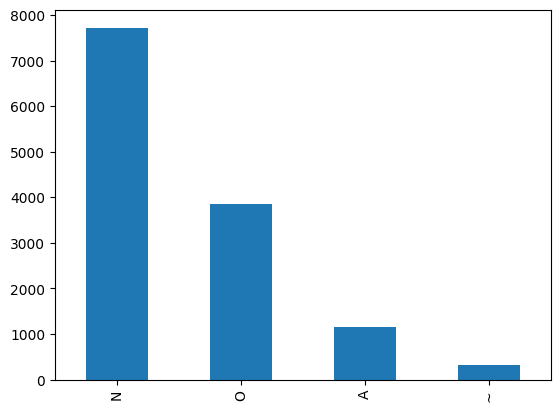

In [14]:
# check class imbalance
y = raw_signal['Type']
unique_types = set(y)
# how unbalanced are the labels
print(raw_signal.Type.value_counts())
raw_signal.Type.value_counts().plot.bar()

<ipython-input-12-a7c3b4877b88>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = raw_signal.groupby(['Type']).std()


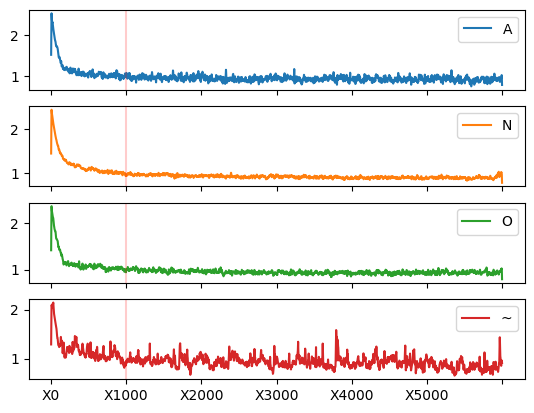

In [12]:
# check variance of data
grouped = raw_signal.groupby(['Type']).std()
ax = grouped.T.plot.line(subplots=True)
for a in ax:
    a.axvline(1000, c='r', alpha=0.2, ds='steps')

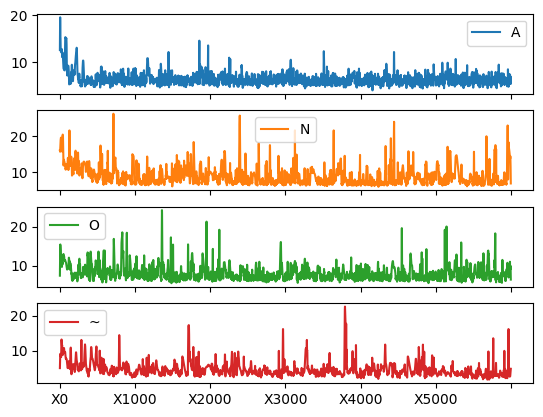

In [13]:
# check min and max values of readings
grouped = raw_signal.groupby(['Type']).max().drop('ID', axis=1)
ax = grouped.T.plot.line(subplots=True)

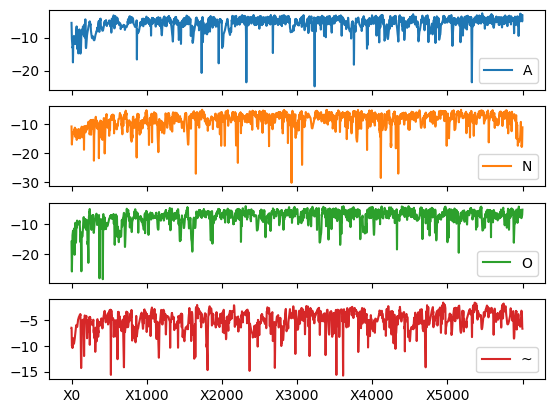

In [14]:
grouped = raw_signal.groupby(['Type']).min().drop('ID', axis=1)
ax = grouped.T.plot.line(subplots=True)

In [15]:
# missing values
nans = raw_signal.isna().sum().sum()
print(f'Total missing values: {nans}')

Total missing values: 815955


# Preprocess data experiments

In [16]:
data_exploration = raw_signal.copy()

In [17]:
signal = data_exploration.iloc[:,1000:]
signal['Type'] = y
signal['ID'] = data_exploration.iloc[:,0]

In [18]:
y = signal.Type

In [19]:
# replace missing values with 0 -> as if its just a 0 reading
no_missing = signal.fillna(0)

In [20]:
clean_X = no_missing.drop(['ID', 'Type'], axis=1)

In [21]:
def replace_outliers_with_nan(df, column, threshold=3):
    """Replace outliers in a dataframe column with NaNs."""
    mean = np.mean(df[column])
    std = np.std(df[column])
    cutoff = std * threshold
    lower, upper = mean - cutoff, mean + cutoff
    df[column] = np.where(np.logical_or(df[column] < lower, df[column] > upper), np.nan, df[column])
    return df

# Apply the function to each column in the dataframe containing ECG data
for col in clean_X:
    clean_X = replace_outliers_with_nan(clean_X, col)
    
clean_X = clean_X.fillna(0)

In [22]:
# scale data to a standard scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(clean_X)

scaled_data=pd.DataFrame(scaler.fit_transform(clean_X),columns=clean_X.columns)
scaled_data['Type'] = y
print(scaled_data.columns)
print(scaled_data.info)

Index(['X998', 'X999', 'X1000', 'X1001', 'X1002', 'X1003', 'X1004', 'X1005',
       'X1006', 'X1007',
       ...
       'X5991', 'X5992', 'X5993', 'X5994', 'X5995', 'X5996', 'X5997', 'X5998',
       'X5999', 'Type'],
      dtype='object', length=5003)
<bound method DataFrame.info of            X998      X999     X1000     X1001     X1002     X1003     X1004  \
0      1.230985  1.264665  1.286031  1.299967  1.277889  1.194302  1.131755   
1     -2.690672 -2.021635 -1.349805 -0.753697 -0.352010 -0.208394 -0.153971   
2      1.048095  0.994748  0.946820  0.885352  0.842228  0.785240  0.743690   
3      0.955952  0.698397  0.493612  0.345936  0.257636  0.204814  0.185759   
4      1.172349  1.139446  1.108084  1.058686  0.986985  0.879214  0.783739   
...         ...       ...       ...       ...       ...       ...       ...   
13057 -1.293172 -1.310670 -1.322001 -1.336100 -1.343032 -1.347134 -1.347170   
13058 -0.215379 -0.187874 -0.147274 -0.081160  0.041894  0.161973  0.271382   
13059

## visualise some signals

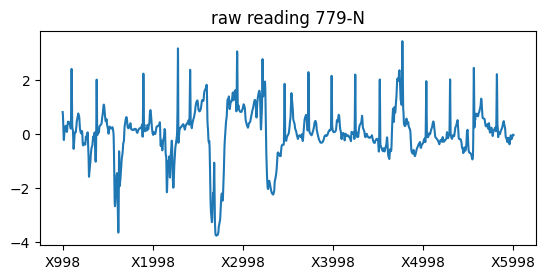

Text(0.5, 1.0, 'scaled reading 779-N')

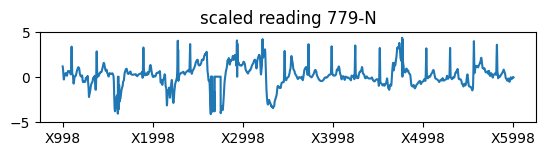

In [23]:
import random
reading = random.randint(0, 1000)
original_signal = no_missing.iloc[reading]
original_signal.drop(['Type', 'ID']).plot()
plt.gca().set_aspect(300)

plt.title(f'raw reading {reading}-{original_signal.Type}')
plt.show()
plt.clf()
scaled_signal = scaled_data.iloc[reading]
scaled_signal.drop(['Type']).plot()
plt.ylim((-5, 5))
plt.gca().set_aspect(100)

plt.title(f'scaled reading {reading}-{scaled_signal.Type}')

In [24]:
print(scaled_data.Type)

0        N
1        N
2        N
3        ~
4        ~
        ..
13057    O
13058    O
13059    O
13060    N
13061    N
Name: Type, Length: 13062, dtype: object


X998    0.722803
Name: 15, dtype: object


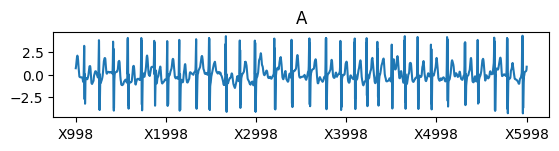

X998    0.955952
Name: 3, dtype: object


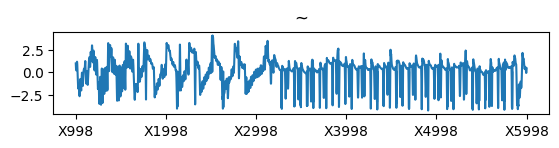

X998    1.230985
Name: 0, dtype: object


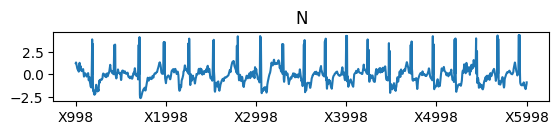

X998   -0.674698
Name: 7, dtype: object


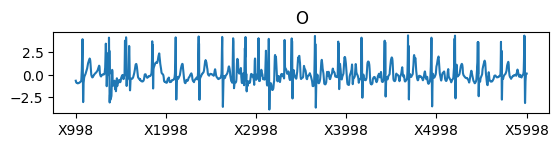

In [25]:
import random
for tpe in unique_types:
    plt.clf()
    for i in range(1):
        first_instance = scaled_data.loc[scaled_data.Type == tpe].iloc[0]
        print(first_instance.head(1))
        feats = first_instance.drop('Type')
        feats.plot() 
    plt.gca().set_aspect(100)
    plt.title(tpe)
    plt.show()

In [26]:
print(scaled_data.columns)

Index(['X998', 'X999', 'X1000', 'X1001', 'X1002', 'X1003', 'X1004', 'X1005',
       'X1006', 'X1007',
       ...
       'X5991', 'X5992', 'X5993', 'X5994', 'X5995', 'X5996', 'X5997', 'X5998',
       'X5999', 'Type'],
      dtype='object', length=5003)


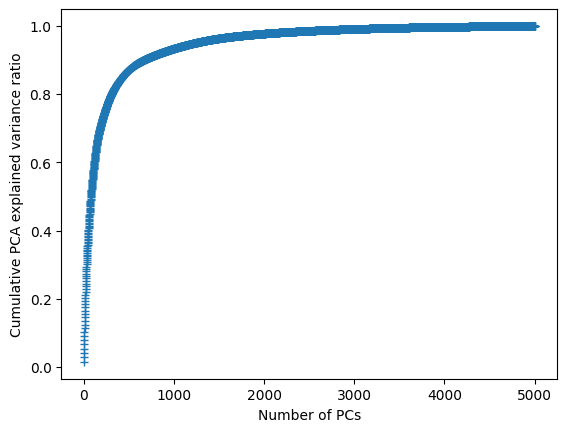

In [27]:
from sklearn.decomposition import PCA

X_pca = scaled_data.drop('Type', axis=1)

pca = PCA()
pca.fit(X_pca)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()

In [28]:
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

[0.39804662 0.55982845 0.61843972 0.64867261]
PCs to exlpain 50% of variance: 79
PCs to exlpain 90% of variance: 664
PCs to exlpain 95% of variance: 1231
PCs to exlpain 99% of variance: 2884


In [29]:
del(scaled_data,clean_X, data_exploration, signal, raw_signal, grouped)

# Preprocess


In [1]:
#import libraries needed
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def replace_outliers_with_nan(df, column, threshold=3):
    """Replace outliers in a dataframe column with NaNs."""
    mean = np.mean(df[column])
    std = np.std(df[column])
    cutoff = std * threshold
    lower, upper = mean - cutoff, mean + cutoff
    df[column] = np.where(np.logical_or(df[column] < lower, df[column] > upper), np.nan, df[column])
    return df

def preprocess(data, pca_components = None, scale = False, remove_outliers = False):
    '''
    data -> X values for dataframe, cannot contain 'ID' or 'Type column'
    '''
    X = data.copy()
    print(X.Type.value_counts())
    try: 
      X.drop(X.loc[~X['Type'].isin(['A', 'N', 'O', '~'])].index, inplace=True)
      print('Dropped wrong label')
    except Exception as e:
      print("Can't find wrong label: ", e)

    print(X.Type.value_counts())

    remove_cols = ['Type', 'ID']
    for name in remove_cols:
        if name in data.columns:
            X = X.drop(name, axis=1)
    
    X = data.iloc[:, 1000:]
    
    X_data = X.fillna(0)
    
    if remove_outliers:
        print("=== Removing Outliers ===")
        for col in X_data:
            X_data = replace_outliers_with_nan(X_data, col)
    
        X_data = X_data.fillna(0)
    
    if scale:
        print("=== Scaling Data ===")
        scaler = StandardScaler()
        scaler.fit(X_data)

        X_data=pd.DataFrame(scaler.fit_transform(X_data),columns=X_data.columns)
    
    if pca_components != None:
        print("=== PCA ===")
        cols = X_data.columns
        pca = PCA(n_components=pca_components).fit(X_data)
        
        X_data = pca.fit_transform(X_data)
        X_data = pd.DataFrame(X_data)
        
    if 'Type' in data.columns:
        X_data['Type'] = data.Type
    
    return X_data

In [3]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def create_train_test(data):
    #encode y values
    y = data.Type
    encoder = preprocessing.LabelEncoder()
    encoded_y = encoder.fit_transform(y)
    
    
    #resample data for balanced labels
    print(f"Before resampling:\n{pd.Series(encoded_y).value_counts()}")

    y_cols = ['Type', 'ID']

    encoded_df = data

    for col in y_cols:
        if col in data:
            encoded_df = data.drop(col, axis=1)

    encoded_df['label'] = encoded_y
    encoded_df= encoded_df.fillna(0)
    Ns = encoded_df[encoded_df.label == 1]
    Os = encoded_df[encoded_df.label == 2]
    As = encoded_df[encoded_df.label == 0]
    noisy = encoded_df[encoded_df.label == 3]

    resample = pd.concat([As, Ns, Os], axis=0)
    resamp_y = resample.label
    resamp_x = resample.drop(['label'], axis=1)
    sm = SMOTE(random_state=6420)
    x_resamp, y_resamp = sm.fit_resample(resamp_x, resamp_y)

    resampled_values = pd.DataFrame(x_resamp)
    resampled_values['label'] = pd.Series(y_resamp.values)

    resampled_data = pd.concat([resampled_values,noisy], axis=0)
    
    print(f'~~~~~~~~~~~~~~~~~~~~\nAfter resampling:\n{resampled_data.label.value_counts()}')
    
    
    #split into test and train
    X_resampled = resampled_data.drop('label', axis=1)
    y_resampled = pd.Series(resampled_data['label'])

    x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state = 6420, stratify=y_resampled)
    print("Train shape: ", x_train.shape, y_train.shape)
    print("Test shape: ", x_test.shape, y_test.shape)
    
    # reshape data for cnn
    X_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
    X_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
    print("X Train shape, resampled: ", X_train.shape)
    print("y train shape, resampled: ", y_train.shape)
    print("X Test shape: ", X_test.shape)
    print("Y test shape: ", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [33]:
data = pd.read_csv('train_signal.csv')
preprocessed = preprocess(data, pca_components=None, scale=True, remove_outliers=True)

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
Dropped wrong label
N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
=== Removing Outliers ===
=== Scaling Data ===


In [35]:
X_train, X_test, y_train, y_test = create_train_test(preprocessed)

Before resampling:
1    7721
2    3857
0    1160
3     324
dtype: int64


<ipython-input-32-a65bd0b6d670>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_values['label'] = pd.Series(y_resamp.values)


~~~~~~~~~~~~~~~~~~~~
After resampling:
0    7721
1    7721
2    7721
3     324
Name: label, dtype: int64
Train shape:  (17615, 5002) (17615,)
Test shape:  (5872, 5002) (5872,)
X Train shape, resampled:  (17615, 5002, 1)
y train shape, resampled:  (17615,)
X Test shape:  (5872, 5002, 1)
Y test shape:  (5872,)


# 1D CNN

In [8]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

def create_cnn_model(input_data, conv_layers, connected_layers, conv_activation='relu', connected_activation='sigmoid'):
    '''create cnn architecture
    input data -> the input training data so the network knows the input shape
    conv_layers (int array) -> array where each element is the amount of filters for each layer
    conv_activation -> activation function for the conv layers
    connected_layers (int array) -> array where each element is the amount of neurons in each layer
    connected_activation -> activation function for connected layer
    '''
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(input_data.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    
    for i in range(len(conv_layers)):
    
        model.add(Conv1D(filters=conv_layers[i], kernel_size=5, activation=conv_activation))
        if i % 2 == 0:
            model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2, strides=2))
    
    model.add(Flatten())
    
    for i in range(len(connected_layers)):
        model.add(Dense(connected_layers[i], activation=connected_activation))
        model.add(Dropout(0.15))

    model.add(Dense(4, activation='softmax'))
    
    return model

In [37]:
cnn_model=create_cnn_model(X_train, [32, 64, 128, 128, 256, 64], [32, 32], 'relu', 'tanh')
cnn_model.compile(optimizer=Adam(), loss = 'sparse_categorical_crossentropy', metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4998, 32)          192       
                                                                 
 batch_normalization (BatchN  (None, 4998, 32)         128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2499, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2495, 32)          5152      
                                                                 
 batch_normalization_1 (Batc  (None, 2495, 32)         128       
 hNormalization)                                                 
                                                        

In [38]:
cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size = 150, validation_split = 0.2, callbacks=early_stopping, verbose=2, workers=-1)

Epoch 1/100
94/94 - 29s - loss: 0.9933 - acc: 0.5378 - val_loss: 1.7035 - val_acc: 0.3247 - 29s/epoch - 304ms/step
Epoch 2/100
94/94 - 10s - loss: 0.7667 - acc: 0.6741 - val_loss: 1.6950 - val_acc: 0.3247 - 10s/epoch - 101ms/step
Epoch 3/100
94/94 - 10s - loss: 0.6846 - acc: 0.7155 - val_loss: 1.7650 - val_acc: 0.3284 - 10s/epoch - 101ms/step
Epoch 4/100
94/94 - 10s - loss: 0.6558 - acc: 0.7308 - val_loss: 1.4028 - val_acc: 0.4195 - 10s/epoch - 108ms/step
Epoch 5/100
94/94 - 10s - loss: 0.6097 - acc: 0.7619 - val_loss: 0.8279 - val_acc: 0.6614 - 10s/epoch - 108ms/step
Epoch 6/100
94/94 - 10s - loss: 0.5911 - acc: 0.7697 - val_loss: 0.6431 - val_acc: 0.7519 - 10s/epoch - 103ms/step
Epoch 7/100
94/94 - 10s - loss: 0.5582 - acc: 0.7904 - val_loss: 0.6660 - val_acc: 0.7511 - 10s/epoch - 103ms/step
Epoch 8/100
94/94 - 10s - loss: 0.5268 - acc: 0.8070 - val_loss: 0.5508 - val_acc: 0.7803 - 10s/epoch - 103ms/step
Epoch 9/100
94/94 - 10s - loss: 0.4850 - acc: 0.8213 - val_loss: 0.5032 - val_ac

Text(0, 0.5, 'Accuracy')

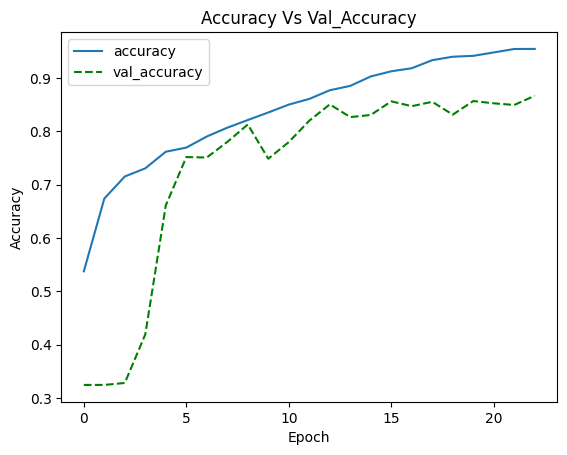

In [39]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

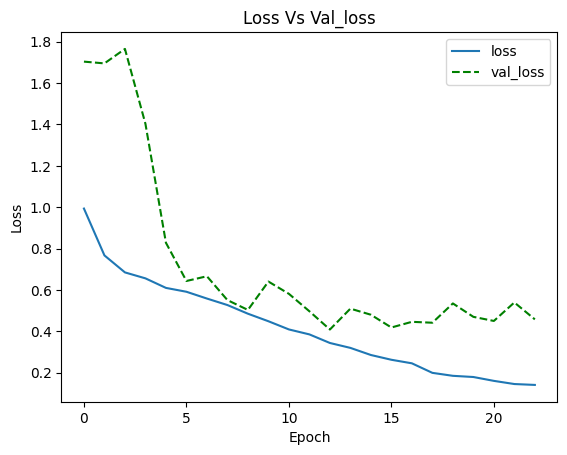

In [40]:
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'], 'g--')
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

184/184 [==============================] - 2s 8ms/step


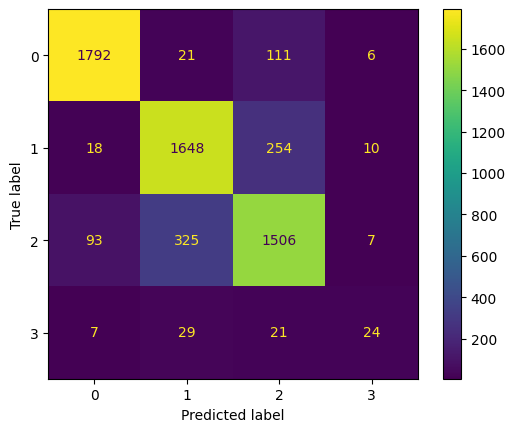

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1930
           1       0.81      0.85      0.83      1930
           2       0.80      0.78      0.79      1931
           3       0.51      0.30      0.37        81

    accuracy                           0.85      5872
   macro avg       0.76      0.71      0.73      5872
weighted avg       0.84      0.85      0.85      5872



In [41]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
y_pred = cnn_model.predict(X_test)
true_pred = np.argmax(y_pred, axis=-1)

cr = classification_report(y_test, true_pred)
ConfusionMatrixDisplay.from_predictions(y_test, true_pred) 
plt.show()
print(cr)

In [46]:
del(X_train, y_train, X_test, y_test, y_pred)

# Experiments

## Include PCA

In [48]:
# include PCA
pca_preprocess = preprocess(data, pca_components = 2884, scale = True, remove_outliers = True)

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
Dropped wrong label
N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
=== Removing Outliers ===
=== Scaling Data ===
=== PCA ===


In [49]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = create_train_test(pca_preprocess)

Before resampling:
1    7721
2    3857
0    1160
3     324
dtype: int64


<ipython-input-32-a65bd0b6d670>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_values['label'] = pd.Series(y_resamp.values)


~~~~~~~~~~~~~~~~~~~~
After resampling:
0    7721
1    7721
2    7721
3     324
Name: label, dtype: int64
Train shape:  (17615, 2884) (17615,)
Test shape:  (5872, 2884) (5872,)
X Train shape, resampled:  (17615, 2884, 1)
y train shape, resampled:  (17615,)
X Test shape:  (5872, 2884, 1)
Y test shape:  (5872,)


In [50]:
pca_cnn_model = create_cnn_model(pca_X_train, [32, 64, 128, 128, 256, 64], [32, 32], 'relu', 'tanh')
pca_cnn_model.compile(optimizer=Adam(), loss = 'sparse_categorical_crossentropy', metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
pca_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2880, 32)          192       
                                                                 
 batch_normalization_4 (Batc  (None, 2880, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1440, 32)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 1436, 32)          5152      
                                                                 
 batch_normalization_5 (Batc  (None, 1436, 32)         128       
 hNormalization)                                                 
                                                      

In [51]:
pca_cnn_model.fit(pca_X_train, pca_y_train, epochs=100, batch_size = 150, validation_split = 0.2, callbacks=early_stopping, verbose=2, workers=-1)

Epoch 1/100
94/94 - 14s - loss: 1.0691 - acc: 0.4762 - val_loss: 1.4973 - val_acc: 0.3162 - 14s/epoch - 148ms/step
Epoch 2/100
94/94 - 6s - loss: 0.9193 - acc: 0.5793 - val_loss: 1.4113 - val_acc: 0.3579 - 6s/epoch - 60ms/step
Epoch 3/100
94/94 - 6s - loss: 0.8212 - acc: 0.6344 - val_loss: 0.9662 - val_acc: 0.5544 - 6s/epoch - 62ms/step
Epoch 4/100
94/94 - 6s - loss: 0.7521 - acc: 0.6724 - val_loss: 0.9144 - val_acc: 0.6137 - 6s/epoch - 60ms/step
Epoch 5/100
94/94 - 6s - loss: 0.6787 - acc: 0.7076 - val_loss: 0.7315 - val_acc: 0.6923 - 6s/epoch - 62ms/step
Epoch 6/100
94/94 - 6s - loss: 0.6283 - acc: 0.7322 - val_loss: 0.7818 - val_acc: 0.6895 - 6s/epoch - 60ms/step
Epoch 7/100
94/94 - 6s - loss: 0.5641 - acc: 0.7605 - val_loss: 0.7643 - val_acc: 0.6821 - 6s/epoch - 62ms/step
Epoch 8/100
94/94 - 6s - loss: 0.5387 - acc: 0.7755 - val_loss: 0.6499 - val_acc: 0.7323 - 6s/epoch - 62ms/step
Epoch 9/100
94/94 - 6s - loss: 0.5023 - acc: 0.7880 - val_loss: 0.7270 - val_acc: 0.6903 - 6s/epoch -

Text(0, 0.5, 'Accuracy')

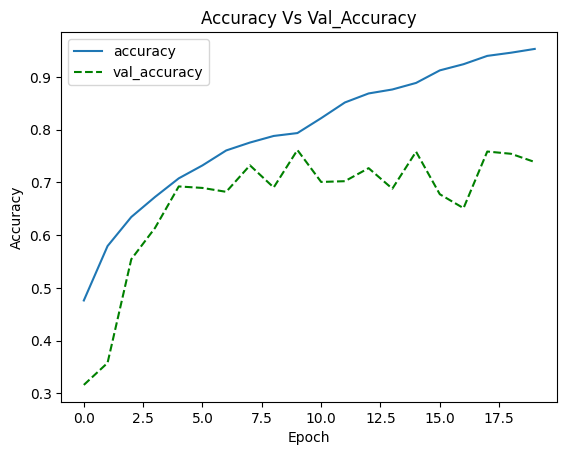

In [52]:
plt.plot(pca_cnn_model.history.history['acc'])
plt.plot(pca_cnn_model.history.history['val_acc'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

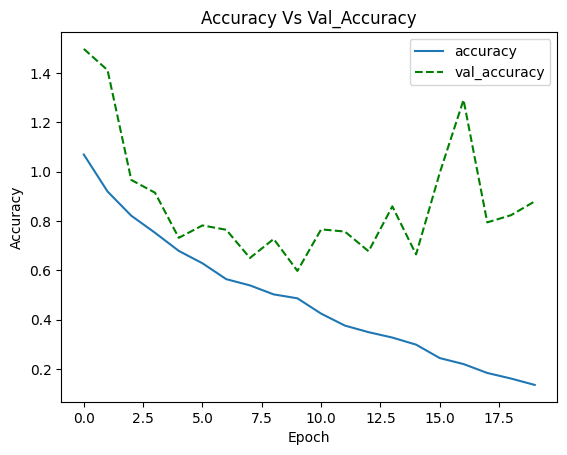

In [53]:
plt.plot(pca_cnn_model.history.history['loss'])
plt.plot(pca_cnn_model.history.history['val_loss'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

184/184 [==============================] - 1s 5ms/step


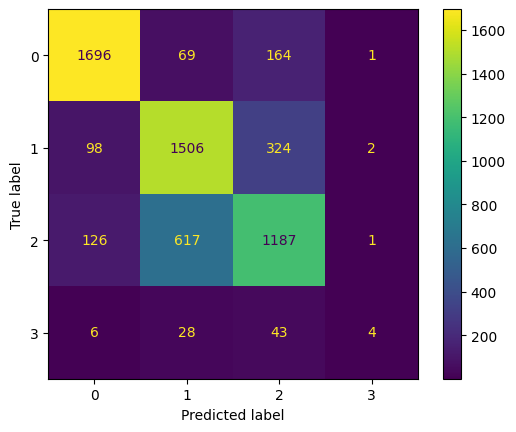

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1930
           1       0.68      0.78      0.73      1930
           2       0.69      0.61      0.65      1931
           3       0.50      0.05      0.09        81

    accuracy                           0.75      5872
   macro avg       0.69      0.58      0.59      5872
weighted avg       0.75      0.75      0.74      5872



In [54]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
pca_y_pred = pca_cnn_model.predict(pca_X_test)
pca_true_pred = np.argmax(pca_y_pred, axis=-1)

cr = classification_report(pca_y_test, pca_true_pred)
ConfusionMatrixDisplay.from_predictions(pca_y_test, pca_true_pred) 
plt.show()
print(cr)

In [55]:
del(pca_y_pred, pca_true_pred)

## model over fits, make less complex, add regularisation L1 & L2 in layers

In [57]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

def create_regularised_cnn_model(input_data, conv_layers, connected_layers, conv_activation='relu', connected_activation='sigmoid'):
    '''create cnn architecture
    input data -> the input training data so the network knows the input shape
    conv_layers (int array) -> array where each element is the amount of filters for each layer
    conv_activation -> activation function for the conv layers
    connected_layers (int array) -> array where each element is the amount of neurons in each layer
    connected_activation -> activation function for connected layer
    '''
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(input_data.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    
    for i in range(len(conv_layers)):
    
        model.add(Conv1D(filters=conv_layers[i], kernel_size=5, activation=conv_activation, kernel_regularizer=regularizers.l2(l=0.01)))
        if i % 2 == 0:
            model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2, strides=2))
    
    model.add(Flatten())
    
    for i in range(len(connected_layers)):
        model.add(Dense(connected_layers[i], activation=connected_activation))
        model.add(Dropout(0.15))

    model.add(Dense(4, activation='softmax'))
    
    return model

In [58]:
less_complex_pca_cnn = create_regularised_cnn_model(pca_X_train, [32, 64, 64, 32], [10, 10], 'relu', 'tanh')
less_complex_pca_cnn.compile(optimizer=Adam(), loss = 'sparse_categorical_crossentropy', metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
less_complex_pca_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 2880, 32)          192       
                                                                 
 batch_normalization_8 (Batc  (None, 2880, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 1440, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 1436, 32)          5152      
                                                                 
 batch_normalization_9 (Batc  (None, 1436, 32)         128       
 hNormalization)                                                 
                                                      

In [59]:
less_complex_pca_cnn.fit(pca_X_train, pca_y_train, epochs=100, batch_size = 150, validation_split = 0.2, callbacks=early_stopping, verbose=2, workers=-1)

Epoch 1/100
94/94 - 10s - loss: 2.4557 - acc: 0.4389 - val_loss: 2.0686 - val_acc: 0.3247 - 10s/epoch - 112ms/step
Epoch 2/100
94/94 - 4s - loss: 1.4978 - acc: 0.5424 - val_loss: 1.4944 - val_acc: 0.4221 - 4s/epoch - 46ms/step
Epoch 3/100
94/94 - 4s - loss: 1.1246 - acc: 0.6143 - val_loss: 1.1225 - val_acc: 0.5620 - 4s/epoch - 43ms/step
Epoch 4/100
94/94 - 4s - loss: 0.9850 - acc: 0.6418 - val_loss: 1.0409 - val_acc: 0.5907 - 4s/epoch - 42ms/step
Epoch 5/100
94/94 - 4s - loss: 0.9018 - acc: 0.6724 - val_loss: 0.9828 - val_acc: 0.6168 - 4s/epoch - 46ms/step
Epoch 6/100
94/94 - 4s - loss: 0.8470 - acc: 0.6959 - val_loss: 0.8222 - val_acc: 0.7039 - 4s/epoch - 43ms/step
Epoch 7/100
94/94 - 4s - loss: 0.8083 - acc: 0.7093 - val_loss: 0.8070 - val_acc: 0.7122 - 4s/epoch - 43ms/step
Epoch 8/100
94/94 - 4s - loss: 0.7906 - acc: 0.7184 - val_loss: 0.7926 - val_acc: 0.7162 - 4s/epoch - 46ms/step
Epoch 9/100
94/94 - 4s - loss: 0.7534 - acc: 0.7327 - val_loss: 0.8372 - val_acc: 0.7003 - 4s/epoch -

Text(0, 0.5, 'Accuracy')

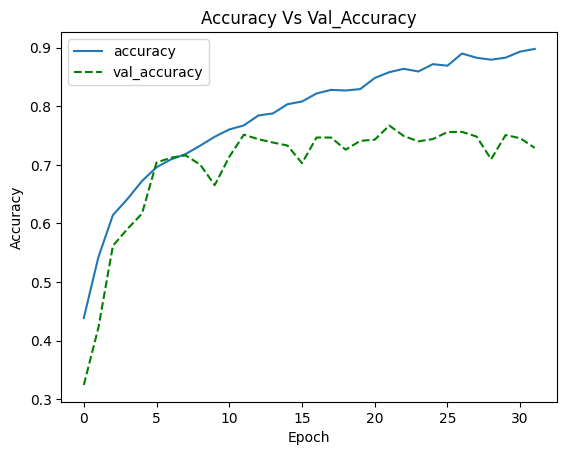

In [60]:
plt.plot(less_complex_pca_cnn.history.history['acc'])
plt.plot(less_complex_pca_cnn.history.history['val_acc'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

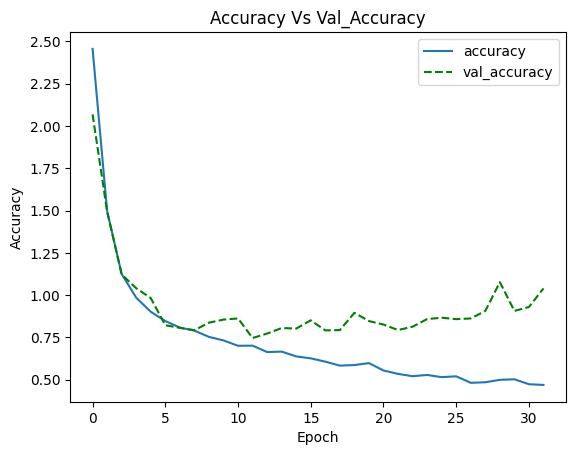

In [61]:
plt.plot(less_complex_pca_cnn.history.history['loss'])
plt.plot(less_complex_pca_cnn.history.history['val_loss'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

184/184 [==============================] - 1s 4ms/step


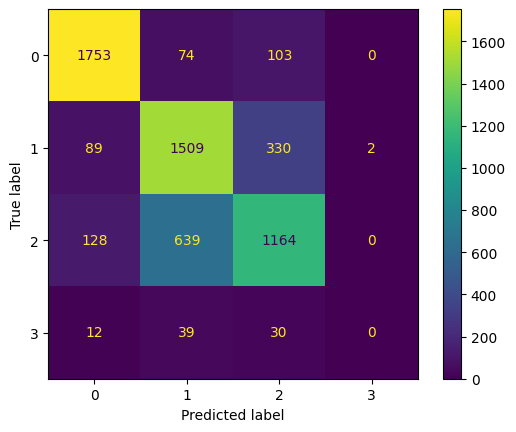

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1930
           1       0.67      0.78      0.72      1930
           2       0.72      0.60      0.65      1931
           3       0.00      0.00      0.00        81

    accuracy                           0.75      5872
   macro avg       0.57      0.57      0.57      5872
weighted avg       0.75      0.75      0.75      5872



In [62]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
less_complex_pca_y_pred = less_complex_pca_cnn.predict(pca_X_test)
less_complex_pca_true_pred = np.argmax(less_complex_pca_y_pred, axis=-1)

cr = classification_report(pca_y_test, less_complex_pca_true_pred)
ConfusionMatrixDisplay.from_predictions(pca_y_test, less_complex_pca_true_pred) 
plt.show()
print(cr)

In [63]:
del(less_complex_pca_y_pred, less_complex_pca_true_pred)

In [64]:
del(pca_X_train, pca_y_train)

# No PCA, connected section more weights than feature section, 

In [5]:
heavy_connected_preprocessed = preprocess(data, pca_components=None, scale=True, remove_outliers=True)

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
Dropped wrong label
N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
=== Removing Outliers ===
=== Scaling Data ===


In [6]:
heavy_connected_X_train, heavy_connected_X_test, heavy_connected_y_train, heavy_connected_y_test = create_train_test(heavy_connected_preprocessed)

Before resampling:
1    7721
2    3857
0    1160
3     324
dtype: int64


<ipython-input-3-a65bd0b6d670>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_values['label'] = pd.Series(y_resamp.values)


~~~~~~~~~~~~~~~~~~~~
After resampling:
0    7721
1    7721
2    7721
3     324
Name: label, dtype: int64
Train shape:  (17615, 5002) (17615,)
Test shape:  (5872, 5002) (5872,)
X Train shape, resampled:  (17615, 5002, 1)
y train shape, resampled:  (17615,)
X Test shape:  (5872, 5002, 1)
Y test shape:  (5872,)


In [9]:
heavy_connected_cnn_model = create_cnn_model(heavy_connected_X_train, [32, 64, 64], [64, 32, 32, 10], 'relu', 'tanh')
heavy_connected_cnn_model.compile(optimizer=Adam(), loss = 'sparse_categorical_crossentropy', metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
heavy_connected_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4998, 32)          192       
                                                                 
 batch_normalization (BatchN  (None, 4998, 32)         128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2499, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2495, 32)          5152      
                                                                 
 batch_normalization_1 (Batc  (None, 2495, 32)         128       
 hNormalization)                                                 
                                                        

In [10]:
heavy_connected_cnn_model.fit(heavy_connected_X_train, heavy_connected_y_train, epochs=100, batch_size = 150, validation_split = 0.2, callbacks=early_stopping, verbose=2, workers=-1)

Epoch 1/100
94/94 - 24s - loss: 0.9358 - acc: 0.5787 - val_loss: 2.5681 - val_acc: 0.0131 - 24s/epoch - 254ms/step
Epoch 2/100
94/94 - 7s - loss: 0.7228 - acc: 0.6837 - val_loss: 2.4367 - val_acc: 0.0474 - 7s/epoch - 72ms/step
Epoch 3/100
94/94 - 7s - loss: 0.6397 - acc: 0.7298 - val_loss: 2.2467 - val_acc: 0.0596 - 7s/epoch - 71ms/step
Epoch 4/100
94/94 - 7s - loss: 0.5698 - acc: 0.7684 - val_loss: 1.0388 - val_acc: 0.6006 - 7s/epoch - 72ms/step
Epoch 5/100
94/94 - 7s - loss: 0.5019 - acc: 0.7990 - val_loss: 0.7396 - val_acc: 0.6889 - 7s/epoch - 73ms/step
Epoch 6/100
94/94 - 7s - loss: 0.4639 - acc: 0.8183 - val_loss: 0.7219 - val_acc: 0.7179 - 7s/epoch - 71ms/step
Epoch 7/100
94/94 - 7s - loss: 0.4049 - acc: 0.8452 - val_loss: 0.6332 - val_acc: 0.7579 - 7s/epoch - 72ms/step
Epoch 8/100
94/94 - 7s - loss: 0.3687 - acc: 0.8625 - val_loss: 0.6084 - val_acc: 0.7755 - 7s/epoch - 71ms/step
Epoch 9/100
94/94 - 7s - loss: 0.3478 - acc: 0.8701 - val_loss: 0.6158 - val_acc: 0.7758 - 7s/epoch -

Text(0, 0.5, 'Accuracy')

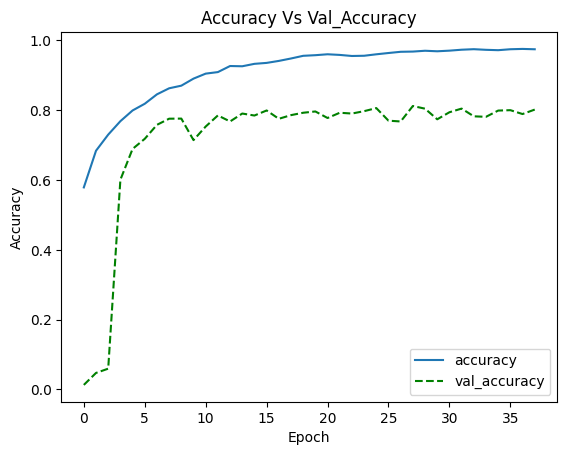

In [11]:
plt.plot(heavy_connected_cnn_model.history.history['acc'])
plt.plot(heavy_connected_cnn_model.history.history['val_acc'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

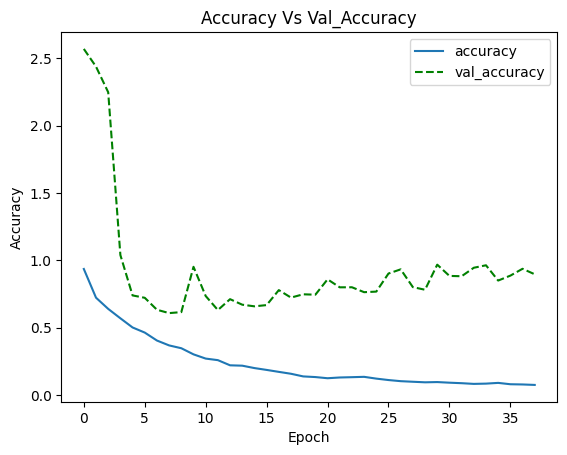

In [12]:
plt.plot(heavy_connected_cnn_model.history.history['loss'])
plt.plot(heavy_connected_cnn_model.history.history['val_loss'], 'g--')
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

184/184 [==============================] - 1s 6ms/step


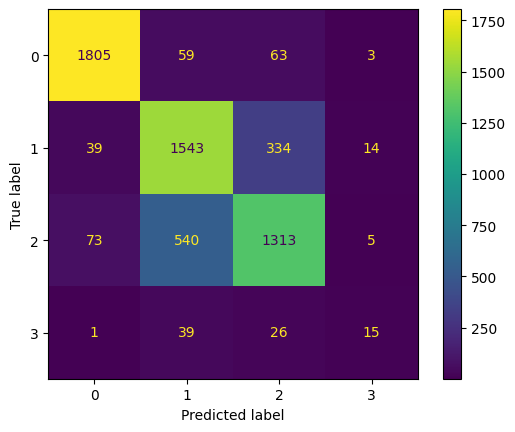

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1930
           1       0.71      0.80      0.75      1930
           2       0.76      0.68      0.72      1931
           3       0.41      0.19      0.25        81

    accuracy                           0.80      5872
   macro avg       0.70      0.65      0.66      5872
weighted avg       0.80      0.80      0.79      5872



In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
heavy_connected_y_pred = heavy_connected_cnn_model.predict(heavy_connected_X_test)
heavy_connected_true_pred = np.argmax(heavy_connected_y_pred, axis=-1)

cr = classification_report(heavy_connected_y_test, heavy_connected_true_pred)
ConfusionMatrixDisplay.from_predictions(heavy_connected_y_test, heavy_connected_true_pred) 
plt.show()
print(cr)

In [14]:
del(heavy_connected_y_pred, heavy_connected_true_pred)

In [15]:
del(heavy_connected_X_train, heavy_connected_X_test, heavy_connected_y_train, heavy_connected_y_test)

# Submission

In [ ]:
label_data = pd.read_csv('train_feat.csv')
y = label_data.Type
encoder = preprocessing.LabelEncoder()
encoded_y = encoder.fit_transform(y)
print(np.unique(encoded_y))

In [ ]:
data = pd.read_csv('test_signal.csv')
test_preprocessed = preprocess(data, pca_components=None, scale=True, remove_outliers=True)

In [ ]:
test_data = np.array(test_preprocessed).reshape(test_preprocessed.shape[0], test_preprocessed.shape[1], 1)
predictions = cnn_model.predict(test_data)
true_pred = np.argmax(predictions, axis=-1)
label_predictions = encoder.inverse_transform(true_pred)
ids = data.ID
submission_dict = {"ID": ids, "Predicted": label_predictions}
final = pd.DataFrame.from_dict(submission_dict)
final.to_csv(f"submission.csv", index=False)